<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 3, 2020, 23:59</center></h1>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

When the dataset is loaded, construct train and test matrices, by allocating **first 400 samples** to train and the rest to test. ___Do not shuffle or randomly sample the feature matrix___.

In [1]:
import numpy as np
import numpy.ma as ma
from sklearn.datasets import load_boston
import seaborn as sns
from matplotlib import pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/sadullahgultekin/miniconda3/envs/pytorch-1.4/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

In [2]:
boston = load_boston()
train_x, train_y = boston.data[:400], boston.target[:400]
test_x, test_y = boston.data[400:], boston.target[400:]

In [3]:
data_for_heatmap = np.concatenate((boston.data, boston.target.reshape(-1,1)), axis=1)

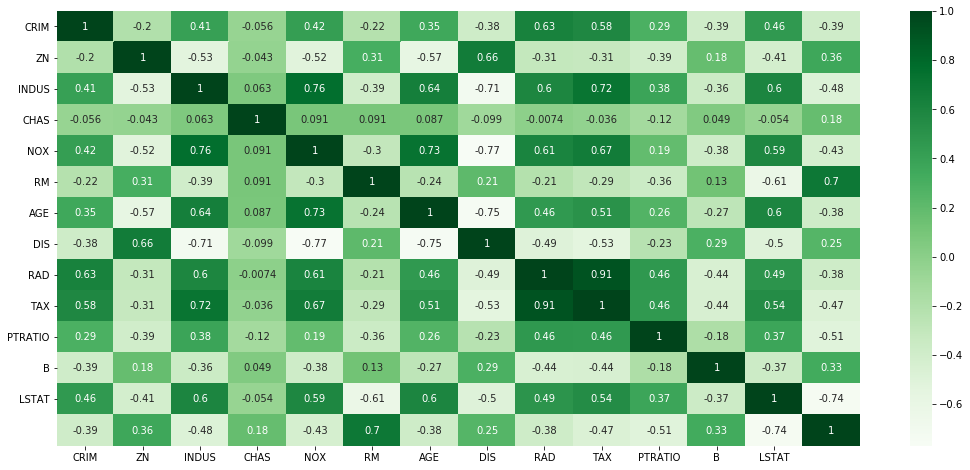

In [4]:
corr = np.corrcoef(data_for_heatmap.T)
plt.figure(figsize = (18,8))
heatmap = sns.heatmap(corr, cmap="Greens", annot=True, 
                      xticklabels=boston.feature_names, 
                      yticklabels=boston.feature_names)

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [5]:
corr_with_price = corr[-1][:-1]
most_negative_rel_index = np.argmin(corr_with_price)
most_negative_rel_name = boston.feature_names[most_negative_rel_index]

most_positive_rel_index = np.argmax(corr_with_price)
most_positive_rel_name = boston.feature_names[most_positive_rel_index]

print(f"Most negatively related feature is {most_negative_rel_name}")
print(f"Most positively related feature is {most_positive_rel_name}")

Most negatively related feature is LSTAT
Most positively related feature is RM


In [6]:
def RSS(features, y, all_thresh):
    repeated_f = np.repeat(features.reshape(-1,1), all_thresh.shape[0], axis=1)
    repeated_y = np.repeat(y.reshape(-1,1), all_thresh.shape[0], axis=1)
    repeated_t = np.repeat(all_thresh.reshape(-1,1), features.shape[0], axis=1)
    
    masked_left = ma.masked_where(repeated_f <= repeated_t.T, repeated_y)
    left_mean = np.mean(masked_left, axis=0)
    left_sum = np.sum((masked_left-left_mean)**2, axis=0)

    masked_right = ma.masked_where(repeated_f > repeated_t.T, repeated_y)
    right_mean = np.mean(masked_right, axis=0)
    right_sum = np.sum((masked_right-right_mean)**2, axis=0)
    
    return (left_sum + right_sum)


In [7]:
rss_positive = RSS(train_x.T[most_positive_rel_index], train_y, np.unique(train_x.T[most_positive_rel_index]))
rss_negative = RSS(train_x.T[most_negative_rel_index], train_y, np.unique(train_x.T[most_negative_rel_index]))
thr_positive = np.unique(train_x.T[most_positive_rel_index])
thr_negative = np.unique(train_x.T[most_negative_rel_index])

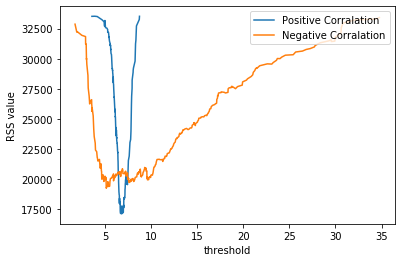

In [8]:
plt.plot(thr_positive, rss_positive, label="Positive Corralation")
plt.plot(thr_negative, rss_negative, label="Negative Corralation")
plt.legend(loc="upper right")
plt.xlabel("threshold")
plt.ylabel("RSS value")
plt.show()

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [11]:
def FindBestFeature(X, y, features):
    rss_for_all_features = []
    for idx, f in enumerate(features):
        related_feature = X[:, idx]
        all_thresh = np.unique(related_feature)
        temp = np.stack((related_feature, y))
        
        all_rss = RSS(related_feature, y, all_thresh)

        min_rss = np.min(all_rss)
        min_rss_thresh = all_thresh[np.argmin(all_rss)]        
        
        rss_for_all_features.append((min_rss, min_rss_thresh))
    
    elem = np.argmin(rss_for_all_features, axis=0)[0]
    return elem, rss_for_all_features[elem]

In [12]:
def DecisionTree(X, y, features, current_depth, max_depth=3):
    if (current_depth > max_depth) or (len(X) == 0):
        return
    index, (rss, thr) = FindBestFeature(X, y, features)
    left_x = X[X.T[index] <= thr]
    left_y = y[X.T[index] <= thr]
    right_x = X[X.T[index] > thr]
    right_y = y[X.T[index] > thr]
    DecisionTree(left_x, left_y, features, current_depth+1, max_depth)
    DecisionTree(right_x, right_y, features, current_depth+1, max_depth)
    
DecisionTree(train_x, train_y, boston.feature_names, 1, max_depth=10)

/Users/sadullahgultekin/miniconda3/envs/pytorch-1.4/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [14]:
class RegressionTree():    
    class Node():
        def __init__(self):
            self.right = None
            self.left = None
            self.attr_index = None
            self.threshold = None
    
    def __init__(self, max_depth=3):
        self.root = Node()
        self.max_depth = max_depth
        self.num_feature = 0
        
    def rss(features, y, all_thresh):
        repeated_f = np.repeat(features.reshape(-1,1), all_thresh.shape[0], axis=1)
        repeated_y = np.repeat(y.reshape(-1,1), all_thresh.shape[0], axis=1)
        repeated_t = np.repeat(all_thresh.reshape(-1,1), features.shape[0], axis=1)

        masked_left = ma.masked_where(repeated_f <= repeated_t.T, repeated_y)
        left_mean = np.mean(masked_left, axis=0)
        left_sum = np.sum((masked_left-left_mean)**2, axis=0)

        masked_right = ma.masked_where(repeated_f > repeated_t.T, repeated_y)
        right_mean = np.mean(masked_right, axis=0)
        right_sum = np.sum((masked_right-right_mean)**2, axis=0)

        return (left_sum + right_sum)

    def find_best_feature(X, y):
        rss_for_all_features = []
        for idx in range(self.num_feature):
            related_feature = X[:, idx]
            all_thresh = np.unique(related_feature)
            temp = np.stack((related_feature, y))

            all_rss = RSS(related_feature, y, all_thresh)

            min_rss = np.min(all_rss)
            min_rss_thresh = all_thresh[np.argmin(all_rss)]        

            rss_for_all_features.append((min_rss, min_rss_thresh))

        elem = np.argmin(rss_for_all_features, axis=0)[0]
        return elem, rss_for_all_features[elem]
    
    def build_tree(self, current_node, x, y, current_depth=1):
        if (current_depth > self.max_depth) or (len(x) == 0):
            return current_node
        index, (rss, thr) = find_best_feature(x, y, features)
        left_x = x[x.T[index] <= thr]
        left_y = y[x.T[index] <= thr]
        right_x = x[x.T[index] > thr]
        right_y = y[x.T[index] > thr]
        current_node.left = build_tree(left_x, left_y, features, current_depth+1)
        current_node.right = build_tree(right_x, right_y, features, current_depth+1)
        return current_node
        
    def fit(self, x, y):
        self.num_feature = x.shape[1]
        build_tree(self.root, x, y)
        return self.root
        

In [ ]:
print(rss_vals)


**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [ ]:
boston